In [35]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Markdown, SVG, HTML
import pandas as pd
import altair as alt
import re
import pickle
from utils import seconds_to_ms, ms_to_seconds
from benchmark_result import get_benchmark_results, BenchmarkType, SchedulerType, get_broadcast_source, get_async_source
from benchmarks.utils import echo
from benchmarks.throughput import make_benchmark, make_multiple_message_benchmark

In [36]:
#benchmark_results = get_benchmark_results()
from benchmark_result import BenchmarkResult, Result 
with open('saved_results.pkl', 'rb') as saved_results:
    benchmark_results = pickle.load(saved_results)

## ipyparallel benchmark results ##

### time_broadcast

This benchmark comes from benchmaring the runtime of sending and returning different size arrays to different number of engines with the echo function on various scheduler implementations


In [37]:
??echo

Signature: echo(delay=0)
Docstring: <no docstring>
Source:   
def echo(delay=0):
    def inner_echo(x, **kwargs):
        import time

        if delay:
            time.sleep(delay)
        return x

    return inner_echo
File:      ~/ipyparallel_master_project/benchmarks/utils.py
Type:      function


In [38]:
??make_benchmark

Signature: make_benchmark(benchmark_name, get_view)
Docstring: <no docstring>
Source:   
def make_benchmark(benchmark_name, get_view):
    class ThroughputSuite:
        param_names = ['Number of engines', 'Number of bytes']
        timer = timeit.default_timer
        timeout = 120
        params = [engines, byte_param]

        view = None
        client = None
        reply = None

        def setup(self, number_of_engines, number_of_bytes):
            self.client = ipp.Client(profile='asv')
            self.view = get_view(self)
            self.view.targets = list(range(number_of_engines))
            wait_for(lambda: len(self.client) >= number_of_engines)

        def time_broadcast(self, engines, number_of_bytes):
            self.reply = self.view.apply_sync(
                echo, np.array([0] * number_of_bytes, dtype=np.int8)
            )

        def teardown(self, *args):
            if self.client:
                self.client.close()

    return ThroughputSuite
File:     

### Results from running benchmark on 64 cores


In [39]:
source = get_broadcast_source(benchmark_results)

In [40]:
dview = pd.DataFrame(source['DirectView']) 
dview['Scheduler name'] = 'DirectView'
dview['Speedup'] = 1


In [41]:
source
datas = []
for scheduler_name, scheduler_results in source.items():
    data = pd.DataFrame(scheduler_results) 
    data['Scheduler name'] = scheduler_name
    data['Speedup'] = dview['Duration in ms'] / data['Duration in ms']
    datas.append(data)
data = pd.concat(datas)
data

,Duration in ms,Number of bytes,Number of engines,Scheduler name,Speedup
0,9.45,1000,1,NonCoalescing,0.484656
1,9.47,10000,1,NonCoalescing,0.587117
2,17.83,100000,1,NonCoalescing,0.722378
3,89.25,1000000,1,NonCoalescing,0.873501
4,172.51,2000000,1,NonCoalescing,0.858733
...,...,...,...,...,...
35,677.21,1000,1024,DirectView,1.000000
36,661.01,10000,1024,DirectView,1.000000
37,760.37,100000,1024,DirectView,1.000000
38,1979.30,1000000,1024,DirectView,1.000000


In [42]:
for scheduler_name in data['Scheduler name'].unique():
    scheduler_data = data[data['Scheduler name'] == scheduler_name]
    alt.Chart(scheduler_data).mark_line(point=True).encode(
        alt.X(
            'Number of bytes',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
            'Duration in ms',
            scale=alt.Scale(type='log')

        ),
        color='Number of engines:N',
        tooltip='Duration in ms',
    
    ).properties(title=scheduler_name, width=800).interactive().display(renderer='svg')


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [9]:
display(Markdown(f'## Results for duration[DirectView]/duration[scheduler]'))
for scheduler_name in data['Scheduler name'].unique():
    if scheduler_name == 'DirectView':
        continue
    alt.Chart(data[data['Scheduler name'] == scheduler_name]).mark_line(point=True).encode(
        alt.X(
            'Number of bytes',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
             'Speedup',
        ),
        color='Number of engines:N',
        tooltip='Number of engines',
    
    ).properties(title=scheduler_name, width=800).interactive().display(renderer='svg')

## Results for duration[DirectView]/duration[scheduler]

alt.Chart(...)

alt.Chart(...)

### Running on 1 engines

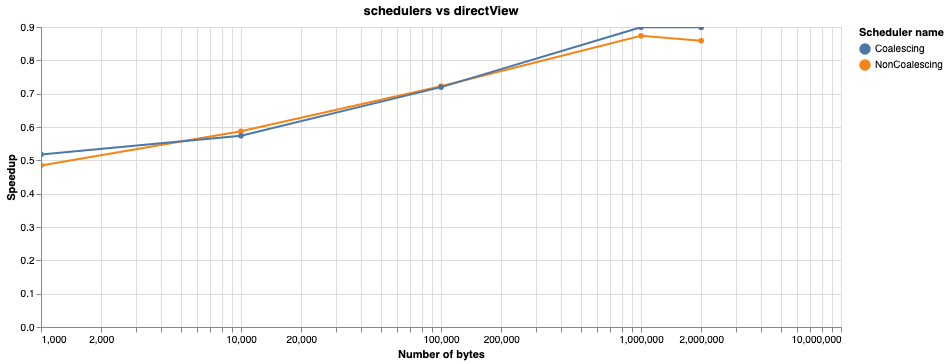

### Running on 2 engines

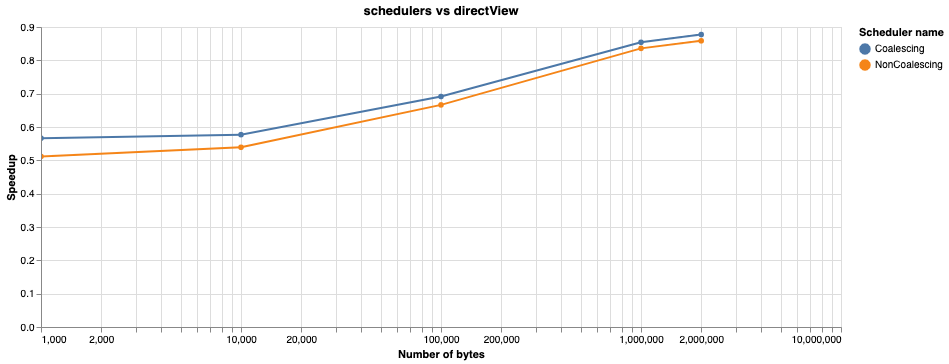

### Running on 16 engines

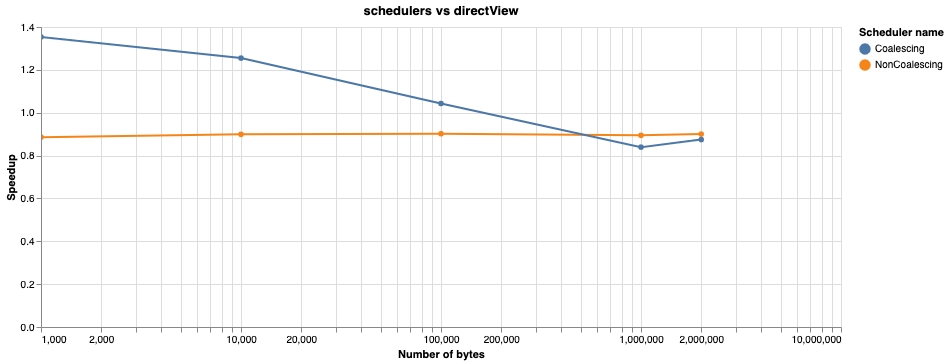

### Running on 64 engines

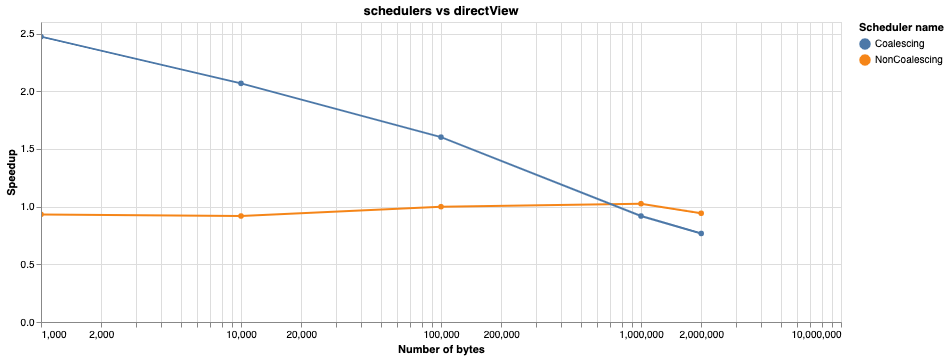

### Running on 128 engines

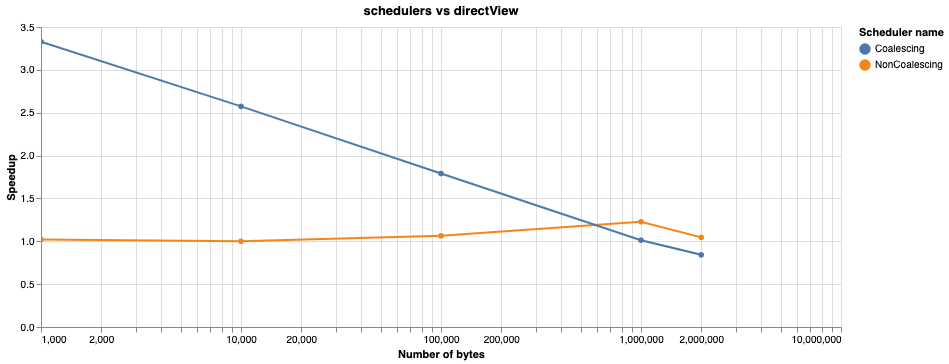

### Running on 256 engines

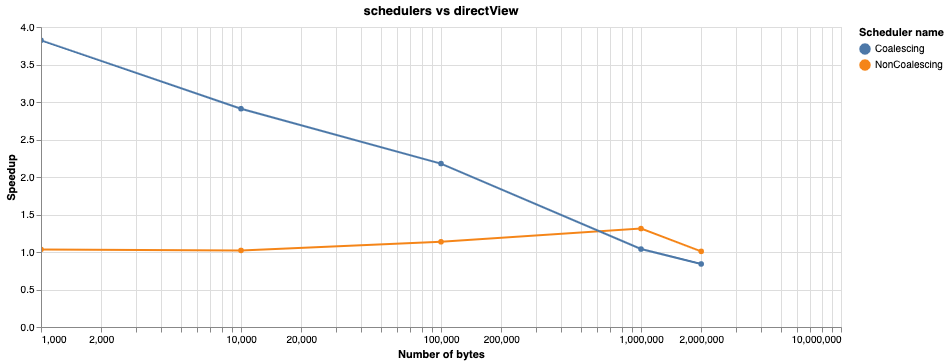

### Running on 512 engines

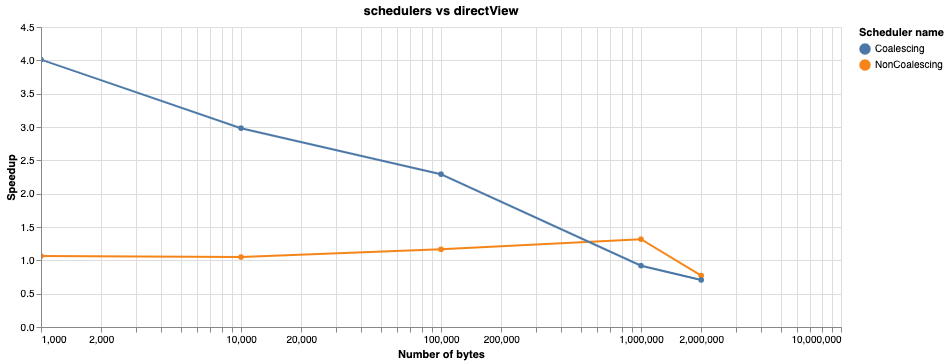

### Running on 1024 engines

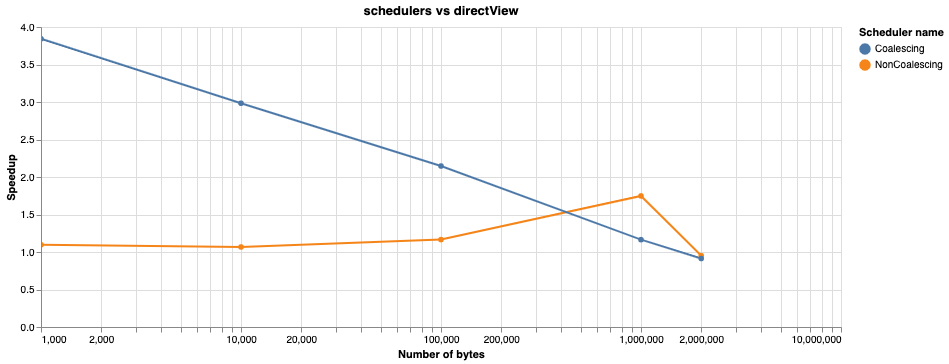

In [17]:

for engine in data['Number of engines'].unique():
    display(Markdown(f'### Running on {engine} engines'))
    alt.Chart(data[(data['Number of engines'] == engine) & (data['Scheduler name'] != 'DirectView')]).mark_line(point=True).encode(
        alt.X(
            'Number of bytes',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
            'Speedup',
        ),
        color='Scheduler name:N',
        tooltip='Duration in ms',
    ).properties(title='schedulers vs directView', width=800).interactive().display(renderer='svg')

In [20]:
data['combined']=  data['Scheduler name'] + ' ' + data['Number of bytes'].astype(str)
alt.Chart(data[data['Scheduler name'] != 'DirectView']).mark_line(point=True).encode(
    alt.X(
        'Number of engines',
            scale=alt.Scale(type='log')
    ),
    alt.Y(
        'Speedup',
    ),
    color='Number of bytes:N',
    strokeDash=alt.StrokeDash(shorthand='Scheduler name', legend=None),
    tooltip='combined',

).properties(title='schedulers vs directView scaling engines', width=800).interactive().display(renderer='svg')


alt.Chart(...)

In [21]:
for engine in data['Number of engines'].unique():    
    alt.Chart(data[data['Number of engines'] == engine]).mark_bar().encode(
        x='Scheduler name',
        y='Duration in ms',
        color='Scheduler name:N',
        column='Number of bytes:N',    
        tooltip='Duration in ms'
    ).properties(title=f'Runtime on {engine} engines:').interactive().display(renderer='svg')

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

## time_async_messages

In [25]:
??make_multiple_message_benchmark

Signature: make_multiple_message_benchmark(get_view)
Docstring: <no docstring>
Source:   
def make_multiple_message_benchmark(get_view):
    class AsyncMessagesSuite:
        param_names = ['Number of engines', 'number_of_messages']
        timer = timeit.default_timer
        timeout = 60
        params = [engines, [1, 10, 100]]

        view = None
        client = None
        reply = None

        def setup(self, number_of_engines, number_of_messages):
            self.client = ipp.Client(profile='asv', cluster_id=f'depth_3')
            self.view = get_view(self)
            self.view.targets = list(range(number_of_engines))

            wait_for(lambda: len(self.client) >= number_of_engines)

        def time_async_messages(
            self, number_of_engines, number_of_messages
        ):
            replies = []
            for i in range(number_of_messages):
                reply = self.view.apply_async(
                    echo(0),
                    np.array([0] * 1000, dt

In [46]:
source = get_async_source(benchmark_results)
dview = pd.DataFrame(source['DirectView']) 
dview['Scheduler name'] = 'DirectView'
dview['Speedup'] = 1


In [47]:
datas = []
for scheduler_name, scheduler_results in source.items():
    data = pd.DataFrame(scheduler_results) 
    data['Scheduler name'] = scheduler_name
    data['Speedup'] = 1 if scheduler_name == 'DirectView' else dview['Duration in ms'] / data['Duration in ms']
    datas.append(data)
data = pd.concat(datas)
data

,Duration in ms,Number of messages,Number of engines,Scheduler name,Speedup
0,4.75,1,1,DirectView,1.000000
1,17.70,5,1,DirectView,1.000000
2,29.59,10,1,DirectView,1.000000
3,58.47,20,1,DirectView,1.000000
4,133.31,50,1,DirectView,1.000000
...,...,...,...,...,...
49,593.23,1,1024,NonCoalescing,5.581141
50,2398.68,5,1024,NonCoalescing,2.804805
51,4529.79,10,1024,NonCoalescing,2.870884
52,8927.69,20,1024,NonCoalescing,NaN


In [48]:
data[data['Scheduler name'] == 'DirectView']

,Duration in ms,Number of messages,Number of engines,Scheduler name,Speedup
0,4.75,1,1,DirectView,1.0
1,17.70,5,1,DirectView,1.0
2,29.59,10,1,DirectView,1.0
3,58.47,20,1,DirectView,1.0
4,133.31,50,1,DirectView,1.0
5,210.77,75,1,DirectView,1.0
6,268.27,100,1,DirectView,1.0
7,5.26,1,2,DirectView,1.0
8,16.47,5,2,DirectView,1.0
9,34.15,10,2,DirectView,1.0


In [51]:
for scheduler_name in data['Scheduler name'].unique():
    scheduler_data = data[data['Scheduler name'] == scheduler_name]
    alt.Chart(scheduler_data).mark_line(point=True).encode(
        alt.X(
            'Number of messages',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
            'Duration in ms',
            scale=alt.Scale(type='log')
        ),
        color='Number of engines:N',
        tooltip='Duration in ms',
    
    ).properties(title=scheduler_name, width=800).interactive().display(renderer='svg')

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [29]:
for engine in data['Number of engines'].unique():
    display(Markdown(f'### Running on {engine} engines'))
    alt.Chart(data[(data['Number of engines'] == engine) & (data['Scheduler name'] != 'DirectView')]).mark_line(point=True).encode(
        alt.X(
            'Number of messages',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
            'Speedup',
        ),
        color='Scheduler name:N',
        tooltip='Duration in ms',
    ).properties(title='schedulers vs directView', width=800).interactive().display(renderer='svg')

### Running on 1 engines

alt.Chart(...)

### Running on 2 engines

alt.Chart(...)

### Running on 16 engines

alt.Chart(...)

### Running on 64 engines

alt.Chart(...)

### Running on 128 engines

alt.Chart(...)

### Running on 256 engines

alt.Chart(...)

### Running on 512 engines

alt.Chart(...)

### Running on 1024 engines

alt.Chart(...)

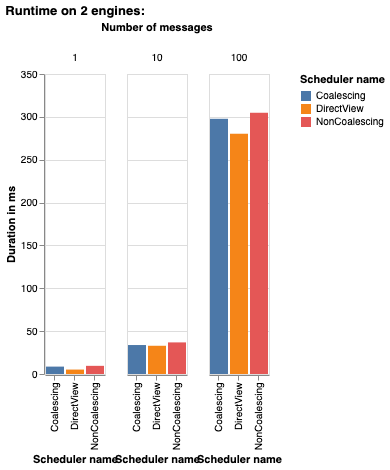

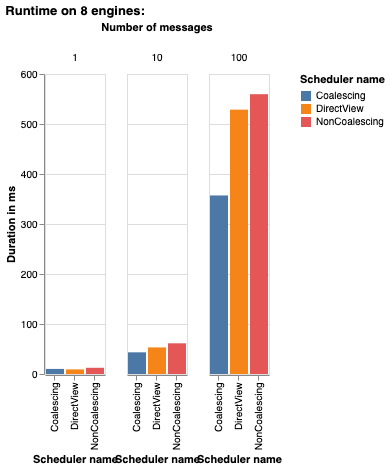

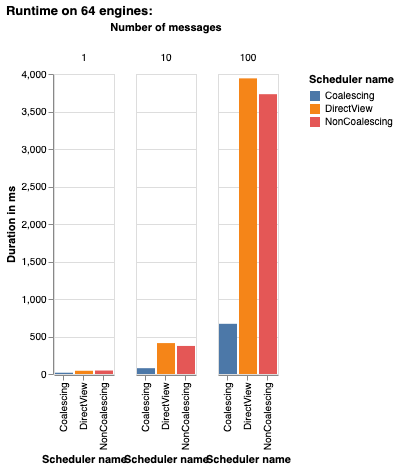

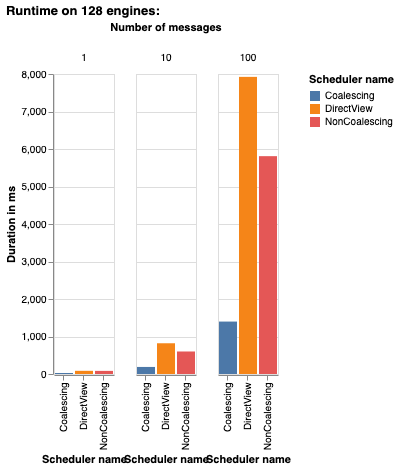

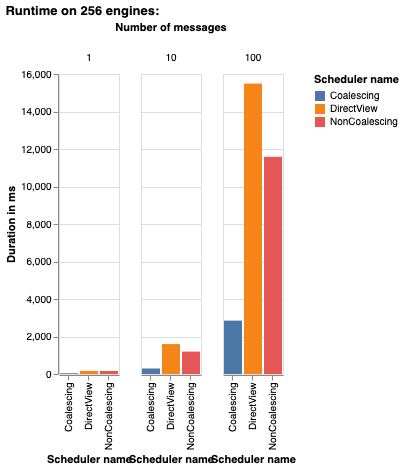

In [32]:
for engine in data['Number of engines'].unique():    
    alt.Chart(data[data['Number of engines'] == engine]).mark_bar().encode(
        x='Scheduler name',
        y='Duration in ms',
        color='Scheduler name:N',
        column='Number of messages:N',    
        tooltip='Duration in ms'
    ).properties(title=f'Runtime on {engine} engines:').interactive().display(renderer='svg')